**==== 1 - Data import and pre-processing ====**

In [ ]:
# dwonload and unzip dataset
!wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip
!unzip /content/complaints.csv.zip -d /content/complaints.csv
# install NLTK
!pip install nltk

In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO

from nltk.stem.snowball import SnowballStemmer

from IPython.display import display

In [ ]:
# load data into a pandas dataframe from csv file
df = pd.read_csv("/content/complaints.csv/complaints.csv",low_memory=False)
df.shape

(2693834, 18)

In [ ]:
# seperate Product & Consumer Complaints columns from initial dataframe
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [ ]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1119247
Debt collection                                                                  425150
Mortgage                                                                         354535
Credit card or prepaid card                                                      145184
Credit reporting                                                                 140430
Checking or savings account                                                      123369
Credit card                                                                       89190
Bank account or service                                                           86206
Student loan                                                                      67011
Money transfer, virtual currency, or money service                                40671
Vehicle loan or lease                                                             33068
Consumer Loan                   

In [ ]:
# check null values on complaints
df.isnull().sum()

Product                               0
Consumer complaint narrative    1750971
dtype: int64

In [ ]:
# keep only 'not null' complaints rows
df = df[pd.notnull(df['Consumer complaint narrative'])] 
df.shape

(942863, 2)

In [ ]:
# since the dataset is imbalanced
# remove products with complaints < 10,000
# remove products with complaints > 100,000 
counts = df['Product'].value_counts()
df = df[~df['Product'].isin(counts[counts < 10000].index)]
df = df[~df['Product'].isin(counts[counts > 100000].index)]
df.shape

(357009, 2)

In [ ]:
df['Product'].value_counts()

Mortgage                                              91969
Credit card or prepaid card                           71415
Checking or savings account                           45394
Credit reporting                                      31588
Student loan                                          30813
Money transfer, virtual currency, or money service    22485
Credit card                                           18838
Vehicle loan or lease                                 17640
Bank account or service                               14885
Payday loan, title loan, or personal loan             11982
Name: Product, dtype: int64

In [ ]:
# remove duplicated rows in dataframe
df = df.drop_duplicates(keep="first")
df.shape

(353019, 2)

In [ ]:
df['Product'].value_counts()

Mortgage                                              91837
Credit card or prepaid card                           70241
Checking or savings account                           45341
Student loan                                          30670
Credit reporting                                      29827
Money transfer, virtual currency, or money service    22199
Credit card                                           18757
Vehicle loan or lease                                 17357
Bank account or service                               14856
Payday loan, title loan, or personal loan             11934
Name: Product, dtype: int64

In [ ]:
# overwrite colum names into 'Product' & 'Consumer_Complaint'
df.columns = ['Product', 'Consumer_Complaint']
df

,Product,Consumer_Complaint
54,Credit card or prepaid card,"Please reopen case XXXX, Nothing has been reso..."
108,Credit card or prepaid card,This was not sent is error i am a consumer by ...
125,Credit card or prepaid card,I bought 2 {$100.00} XXXX gift cards at XXXX a...
138,Vehicle loan or lease,Sun coast credit union committed insurance fra...
147,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...
...,...,...
2693824,Credit card,A reward coupon from XXXX expired and American...
2693826,Credit reporting,Wrong name no XXXX XXXX XXXX and wrong address...
2693828,Credit card,"Automated calls from "" XXXX with Capital One '..."
2693830,Mortgage,My father died in XX/XX/XXXX. Left me his only...


In [ ]:
df.shape

(353019, 2)

In [ ]:
# assign specific id to each product type
df['cid'] = df['Product'].factorize()[0]
df

,Product,Consumer_Complaint,cid
108,Credit card or prepaid card,This was not sent is error i am a consumer by ...,0
125,Credit card or prepaid card,I bought 2 {$100.00} XXXX gift cards at XXXX a...,0
138,Vehicle loan or lease,Sun coast credit union committed insurance fra...,1
147,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...,1
200,Checking or savings account,Banking services or operating as expected. Sun...,2
...,...,...,...
2693824,Credit card,A reward coupon from XXXX expired and American...,9
2693826,Credit reporting,Wrong name no XXXX XXXX XXXX and wrong address...,7
2693828,Credit card,"Automated calls from "" XXXX with Capital One '...",9
2693830,Mortgage,My father died in XX/XX/XXXX. Left me his only...,4


In [ ]:
df['Product'].value_counts()

Mortgage                                              65687
Credit card or prepaid card                           50442
Checking or savings account                           32546
Student loan                                          21942
Credit reporting                                      21563
Money transfer, virtual currency, or money service    15822
Credit card                                           13492
Vehicle loan or lease                                 12443
Bank account or service                               10564
Payday loan, title loan, or personal loan              8518
Name: Product, dtype: int64

In [ ]:
# Text Preprocessing using NLTK
# function definition for stemming, tokenizing, removing stop words and 'XX' values from complaint strings using NLTK
# this will be used on TfidfVectorizer
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
def wordTokenizer(text):
   # tokenize words using nltk word_tokenize operation and remove unnecessary characters
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   # convert complaints data into lowercase
   # tf-idf consider same word in different case (lowercase/uppercase/camelcase/mixed) formats as different words. 
   tokens = map(str.lower, tokens)
   # stem and return tokens that are not in stop words list
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


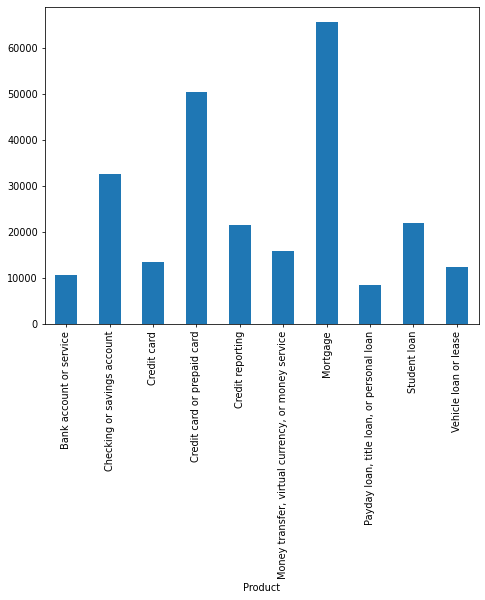

In [ ]:
# data distribution among selected product classes
fig = plt.figure(figsize=(8,6),dpi=70.0)
df.groupby('Product').Consumer_Complaint.count().plot.bar(ylim=0)
plt.show()

==== 2. Creating Feature Vector ====

In [ ]:
# dataframe to map product - category_id 
category_id_df = df[['Product', 'cid']].drop_duplicates().sort_values('cid')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['cid', 'Product']].values)

In [ ]:
nltk.download('punkt')
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=None, lowercase=False, max_features=1000, tokenizer=wordTokenizer)
features = tfidf.fit_transform(df.Consumer_Complaint).toarray()
DocMatrix = pd.DataFrame(features,columns= tfidf.get_feature_names())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
labels = df.cid
features.shape

(253019, 1000)

In [ ]:
N = 2
for Product, cid in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == cid)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [item for item in feature_names if len(item.split(' ')) == 1]
  bigrams = [item for item in feature_names if len(item.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. deposit
. overdraft
  . Most correlated bigrams:
. check account
. overdraft fee
# 'Checking or savings account':
  . Most correlated unigrams:
. branch
. deposit
  . Most correlated bigrams:
. save account
. check account
# 'Credit card':
  . Most correlated unigrams:
. credit
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. loan
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
. credit file
. credit report
# 'Money transfer, virtual currency, or money service':
  . Most correlated unigrams:
. paypal
. coinbas
  . Most correlated bigrams:
. money back
. bank account
# 'Mortgage':
  . Most correlated unigrams:
. modif
. mortgag
  . Most correlated bigrams:
. mortgag payment
. mortgag compani
# 'Payday loan, title loan, or 

**==== 3. Train, Test and Compare Different ML Models ====**

In [ ]:
# Define test and train data
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 0, test_size=0.2)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


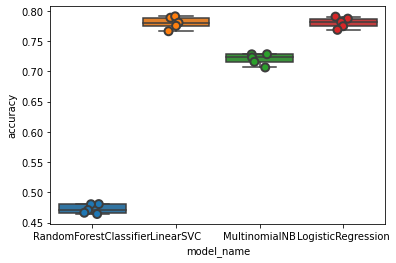

In [ ]:
# Define model array to find the best model for comlaints clasification
modelsArray = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(max_iter=3000),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5 # cross-validation splitting strategy
cv_df = pd.DataFrame(index=range(CV * len(modelsArray)))
entries = []
for model in modelsArray: # itrate through model array
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV) # get cross validation accuracies of models 
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()# Display the accuracies of each models

In [ ]:
cv_df.groupby('model_name').accuracy.mean() # Display accuracy score of each model

model_name
LinearSVC                 0.780499
LogisticRegression        0.780673
MultinomialNB             0.720499
RandomForestClassifier    0.472573
Name: accuracy, dtype: float64

In [ ]:
modelSVC = LinearSVC(dual=False)
modelSVC.fit(features, labels)

LinearSVC(dual=False)

In [ ]:
modelSVC.coef_
modelSVC.intercept_

array([-0.78297156, -1.17451342, -0.8344435 , -0.95396519, -0.72873314,
       -0.84337563, -1.12454416, -0.61271749, -0.99075048, -0.95934587])

In [ ]:
pred = modelSVC.predict(X_test)

In [ ]:
accuracy_score(y_test, pred) 

0.7863212394277133

== LinearSVC model with multiple cost factors ==

In [ ]:
accuracy = []
acc_train = []
coefficient = []
for c in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
    svm = LinearSVC(dual=False, C=c)
    svm.fit(X_train, y_train)
    coef = svm.coef_
    
    p_train = svm.predict(X_train)
    a_train = accuracy_score(y_train, p_train)
    
    pred = svm.predict(X_test)
    a = accuracy_score(y_test, pred)
    
    coefficient.append(coef)
    acc_train.append(a_train)
    accuracy.append(a)

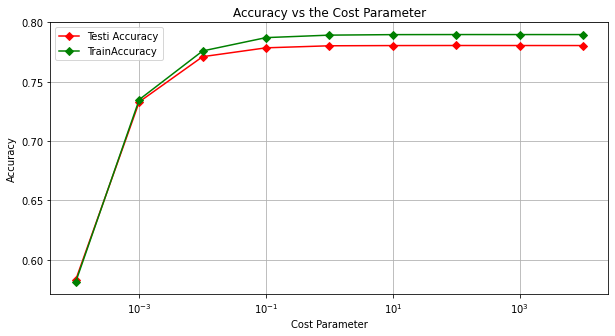

In [ ]:
cp = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

plt.subplots(figsize=(10, 5))
plt.semilogx(cp, accuracy,'-gD' ,color='red' , label="Testi Accuracy")
plt.semilogx(cp, acc_train,'-gD' , label="TrainAccuracy")
plt.grid(True)
plt.xlabel("Cost Parameter")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy vs the Cost Parameter')
plt.show()

== LinearSVC model with Penalty l1 ==

In [ ]:
accuracy = []
acc_train = []
coefficient = []
for c in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
    svm = LinearSVC(dual=False, C=c, penalty='l1', max_iter=3000)
    svm.fit(X_train, y_train)
    coef = svm.coef_
    
    p_train = svm.predict(X_train)
    a_train = accuracy_score(y_train, p_train)
    
    pred = svm.predict(X_test)
    a = accuracy_score(y_test, pred)
    
    coefficient.append(coef)
    acc_train.append(a_train)
    accuracy.append(a)

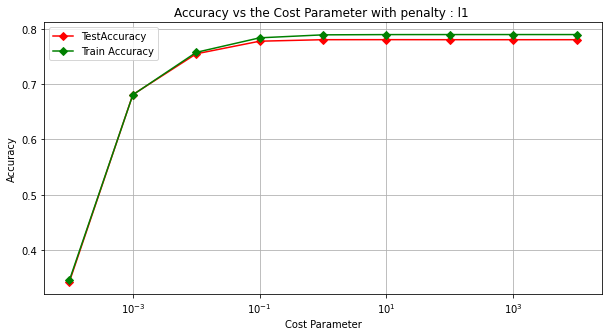

In [ ]:
cp = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

plt.subplots(figsize=(10, 5))
plt.semilogx(cp, accuracy,'-gD' ,color='red' , label="TestAccuracy")
plt.semilogx(cp, acc_train,'-gD' , label="Train Accuracy")
plt.grid(True)
plt.xlabel("Cost Parameter")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy vs the Cost Parameter with penalty : l1 ')
plt.show()

== Save finalized model ==

In [ ]:
finalizedmodel = LinearSVC(dual=False, C=1,  max_iter=2000)
finalizedmodel.fit(X_train, y_train)
pred = finalizedmodel.predict(X_test)
accuracy_score(y_test, pred) 

0.7801952414828868

In [ ]:
filename = 'finalized_model.sav'
joblib.dump(finalizedmodel, filename)

['finalized_model.sav']

**==== 4. Evaluating the performance of the LinearSVC model with performance metrics ====**

from above comparision , we have selected Linear Support Vector Classifier model 

In [ ]:
joblib.load("finalized_model.sav")
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# 'Bank account or service':
  . Top unigrams:
       . bank
       . overdraft
  . Top bigrams:
       . check account
       . debit card
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . deposit
  . Top bigrams:
       . debit card
       . credit union
# 'Credit card':
  . Top unigrams:
       . card
       . barclay
  . Top bigrams:
       . credit card
       . american express
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . barclay
  . Top bigrams:
       . american express
       . credit limit
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . transunion
  . Top bigrams:
       . student loan
       . credit card
# 'Money transfer, virtual currency, or money service':
  . Top unigrams:
       . coinbas
       . paypal
  . Top bigrams:
       . credit card
       . chase bank
# 'Mortgage':
  . Top unigrams:
       . mortgag
       . escrow
  . Top bigrams:
       . loan offic
       . loan servic
# 'Payday loan, t

== **Accuracy of the model** ==

In [ ]:
#Deriving the accuracy of the model using the predefined function in sklearn library
model_accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Model Accuracy : {model_accuracy}")

Model Accuracy : 0.781440202355545



  **== Precision of the model** (Calculate precision of this multi class classification through )  ==

*    **Macro averaged precision**: calculate precision for all classes individually and then average them
*    **Micro averaged precision**: calculate class wise true positive and false positive and then use that to calculate overall precision

In [ ]:
#Deriving the Macro & Micro precision of the model using the predefined function in sklearn library
macro_averaged_precision = metrics.precision_score(y_test, y_pred, average = 'macro')
micro_averaged_precision = metrics.precision_score(y_test, y_pred, average = 'micro')

print(f"Macro-Averaged Precision score : {macro_averaged_precision}")
print(f"Micro-Averaged Precision score : {micro_averaged_precision}")

Macro-Averaged Precision score : 0.7082412210007472
Micro-Averaged Precision score : 0.781440202355545



   == **Recall of the model** (Calculate recall of this multi class classification through) ==

*    **Macro averaged recall** : calculate recall for all classes individually and then average them
*    **Micro averaged recall** : calculate class wise true positive and false negative and then use that to calculate overall recall

In [ ]:
micro_averaged_recall = metrics.recall_score(y_test, y_pred, average = 'micro')
macro_averaged_recall = metrics.recall_score(y_test, y_pred, average = 'macro')
print(f"Micro-Averaged recall score : {micro_averaged_recall}")
print(f"Macro-averaged recall score : {macro_averaged_recall}")

Micro-Averaged recall score : 0.781440202355545
Macro-averaged recall score : 0.6574223772295795


== **F1 Score** (To compute F1 Score of this multi class classification problem) ==


*  **Macro averaged F1 Score**: calculate f1 score of every class and then average them
* **Micro averaged F1 Score**: calculate macro-averaged precision score and macro-averaged recall score and then take there harmonic mean


In [ ]:
macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
micro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'micro')
print(f"Macro-Averaged F1 score : {macro_averaged_f1}")
print(f"Micro-Averaged F1 score : {micro_averaged_f1}")

Macro-Averaged F1 score : 0.6623039101450521
Micro-Averaged F1 score : 0.781440202355545


== **Area under the ROC (Receiver Operating Characteristic) curve** ==

In [ ]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [ ]:
roc_auc_dict = roc_auc_score_multiclass(y_test, y_pred)
roc_auc_dict

{0: 0.8810017662729415,
 1: 0.859260951062185,
 2: 0.8614815410976,
 3: 0.9454021575585456,
 4: 0.9663600711231806,
 5: 0.8361242251463843,
 6: 0.7645849737572681,
 7: 0.9329109388302103,
 8: 0.5712375506545458,
 9: 0.5405217384337149}

== **Confusion Matrix** == 

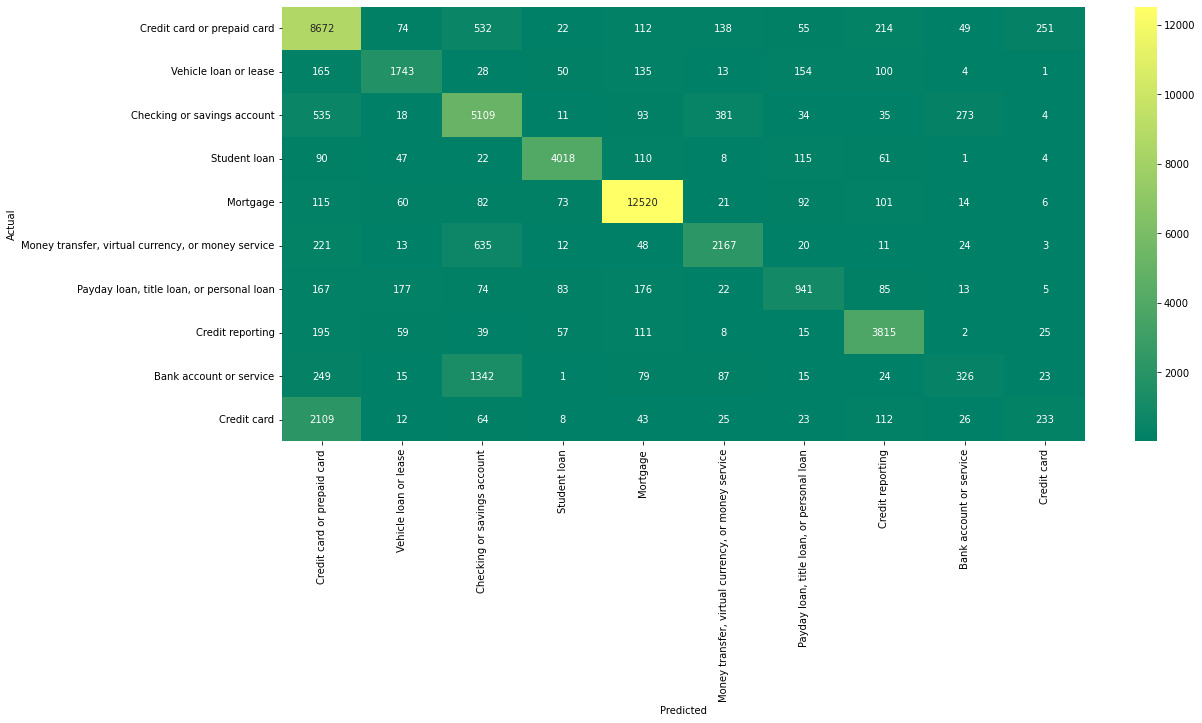

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values, cmap = 'summer')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

== **Model Evaluation Summary** == 

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                    precision    recall  f1-score   support

                       Credit card or prepaid card       0.69      0.86      0.77     10119
                             Vehicle loan or lease       0.79      0.73      0.76      2393
                       Checking or savings account       0.64      0.79      0.71      6493
                                      Student loan       0.93      0.90      0.91      4476
                                          Mortgage       0.93      0.96      0.94     13084
Money transfer, virtual currency, or money service       0.76      0.69      0.72      3154
         Payday loan, title loan, or personal loan       0.64      0.54      0.59      1743
                                  Credit reporting       0.84      0.88      0.86      4326
                           Bank account or service       0.45      0.15      0.23      2161
                                       Credit card       0.42      0.09      0.

== **Summay of incorrect predictions** ==

In [ ]:
for predicted in category_id_df.cid:
  for actual in category_id_df.cid:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_Complaint']])
      print('')

'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 165 examples.


,Product,Consumer_Complaint
2266690,Vehicle loan or lease,"On XX/XX/2021 I, consumer XXXX XXXX certified ..."
2581152,Vehicle loan or lease,I tried calling the XXXX XXXX /Toyota Motors t...
2198209,Vehicle loan or lease,I recently paid off a car loan on a XXXX XXXX ...
1465715,Vehicle loan or lease,On XX/XX/2018 I went to a Toyota dealer to pur...
423442,Vehicle loan or lease,Toyota motor credit Corp decided to report my ...
...,...,...
1081800,Vehicle loan or lease,On or around XXXX XXXX my bill payment company...
1898344,Vehicle loan or lease,missed and late payments reported.
1292904,Vehicle loan or lease,"TODAYS DATE : XXXX/XXXX/XXXX XXXX, XXXX XXXX S..."
1419944,Vehicle loan or lease,I have tried with u all about this debt it com...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 535 examples.


,Product,Consumer_Complaint
1964822,Checking or savings account,My EDD card was frozen because the previous id...
2205486,Checking or savings account,I have not been receiving statements from Chas...
2436164,Checking or savings account,On XX/XX/2021 XXXX with drawed $ XXXXI called ...
1928744,Checking or savings account,"see the bank statement, I been fighting this a..."
367611,Checking or savings account,I called because my card was declined when I w...
...,...,...
1430056,Checking or savings account,My fiance and I travelled to XXXX. While there...
1595022,Checking or savings account,"Just recently I discovered that "" credit Card ..."
2385581,Checking or savings account,"Today, XX/XX/2018 a transaction from XXXX was ..."
470688,Checking or savings account,Would like to be able to pay merchants with XX...



'Student loan' predicted as 'Credit card or prepaid card' : 90 examples.


,Product,Consumer_Complaint
1220045,Student loan,"I have the monthly payment set up on autopay, ..."
272319,Student loan,I received a letter from MyFedLoan on XX/XX/20...
2258462,Student loan,I am person a consumer a natural and not a cre...
2139420,Student loan,I have a loan with DEPTEDNELNET. I have always...
204804,Student loan,Sent payment XX/XX/XXXX. Payment reversed back...
...,...,...
1432060,Student loan,I've seen no changes for the accounts that I h...
2103699,Student loan,I have a loan with DEPTEDNELNET. I have always...
1739392,Student loan,"CALL TO GET FORENSIC AUDIT AND "" FULL VALIDATI..."
1009778,Student loan,I have a loan with ED FINANCIALXXXX. I have al...



'Mortgage' predicted as 'Credit card or prepaid card' : 115 examples.


,Product,Consumer_Complaint
1626457,Mortgage,"I XXXX XXXX XXXX, entered into a consumer cred..."
1833365,Mortgage,I have been victimized by identity theft. The ...
2582393,Mortgage,"My name is XXXX XXXX XXXX, and I am sending th..."
2456786,Mortgage,This particular account situation that is late...
1788752,Mortgage,I recently refinanced with InterContinental Ca...
...,...,...
2179312,Mortgage,In response to case XXXX I didnt realize that ...
1607967,Mortgage,Bank of America Please refer to complaint XXXX...
2056258,Mortgage,I paid my payment on time & they sent in info ...
871637,Mortgage,Unable to access mortgage account online. On X...



'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 221 examples.


,Product,Consumer_Complaint
381301,"Money transfer, virtual currency, or money ser...",cashapp is the worst financial app out here. i...
2071812,"Money transfer, virtual currency, or money ser...",I received notice from XXXX XXXX the credit ca...
1941539,"Money transfer, virtual currency, or money ser...","IM NEW TO PAYPAL, MY GIRLFRIEND SEBT ME SOME M..."
1724151,"Money transfer, virtual currency, or money ser...",Paypal promoted an offering through XX/XX/XXXX...
2370065,"Money transfer, virtual currency, or money ser...",I used square card to take payment for items i...
...,...,...
1653176,"Money transfer, virtual currency, or money ser...",I purchased two reload it cards from a XXXX st...
302989,"Money transfer, virtual currency, or money ser...","On XX/XX/2019, I paid XXXX {$830.00} with my P..."
446791,"Money transfer, virtual currency, or money ser...",The Credit Card Company is HSBC.\n\n1 ) They p...
2537552,"Money transfer, virtual currency, or money ser...","On Monday, XX/XX/2022 I received an unsolicite..."



'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 167 examples.


,Product,Consumer_Complaint
1198901,"Payday loan, title loan, or personal loan",This particular account situation that is late...
2021389,"Payday loan, title loan, or personal loan",I have tried numerous of times to get in touch...
1470493,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I opened an account with the pur...
2231469,"Payday loan, title loan, or personal loan",I have made all payments within the alloted ti...
355763,"Payday loan, title loan, or personal loan",I opened two separate accounts with this compa...
...,...,...
1467110,"Payday loan, title loan, or personal loan",I was told my pay off was XXXX I missed 1 paym...
2567826,"Payday loan, title loan, or personal loan","On XXXX XX/XX/2020, as the COVID-19 pandemic w..."
1046763,"Payday loan, title loan, or personal loan","In late XX/XX/XXXX, I made an additional purch..."
1251174,"Payday loan, title loan, or personal loan","Dear, I usually make payment on time. I made X..."



'Credit reporting' predicted as 'Credit card or prepaid card' : 195 examples.


,Product,Consumer_Complaint
812253,Credit reporting,I was unknowingly and illegally billed by Expe...
1380246,Credit reporting,There is a charge that said XXXX then a credit...
2001644,Credit reporting,By opinion no need to complain I was advised i...
1942984,Credit reporting,The XXXX XXXX XXXX account XXXX is stating Hig...
449708,Credit reporting,I cant access my credit report online with Equ...
...,...,...
1978489,Credit reporting,"RE : Your submission, [ Case number : XXXX ] X..."
318924,Credit reporting,I am trying to be proactive on my credit repor...
2013842,Credit reporting,Look identity thief is the hardest thing to fi...
1986887,Credit reporting,Basically my credit cards have been paid to XX...



'Bank account or service' predicted as 'Credit card or prepaid card' : 249 examples.


,Product,Consumer_Complaint
2037387,Bank account or service,I have made a payment each month as required t...
1955279,Bank account or service,I recently filed a complaint about Chase ; bac...
749908,Bank account or service,I received a netSpend letter in the mail conta...
171985,Bank account or service,I just recently open up an account with CHASE ...
1318405,Bank account or service,"Hello, I need your assistance as these banks a..."
...,...,...
1981834,Bank account or service,"On XXXX XXXX, XXXX, I opened a Small Business ..."
1904065,Bank account or service,"On XXXX/XXXX/16, I received a call from a repr..."
532936,Bank account or service,"To my surprise, on XXXX XXXX, XXXX, I received..."
2070677,Bank account or service,Hi I have a Net Spend Debit Card. NET SPEND OU...



'Credit card' predicted as 'Credit card or prepaid card' : 2109 examples.


,Product,Consumer_Complaint
2094736,Credit card,Credit card solicitation to MINORS by AIRLINEs...
325648,Credit card,XXXX Credit Card is harassing me with collect ...
1991068,Credit card,"I applied for a hotel chain 's credit card, in..."
1995249,Credit card,My credit card account was closed without me r...
1329427,Credit card,"Care Credit Card - Used for Pet, Vision, Medic..."
...,...,...
2042926,Credit card,"I transferred $ XXXX, they charged me a 4 % tr..."
2016726,Credit card,paid off XXXX cards with a settlement now they...
1981909,Credit card,"I had both a XXXX XXXX XXXX "" Fidelity Investm..."
2436951,Credit card,I was called by the telemarketer who had my na...



'Credit card or prepaid card' predicted as 'Vehicle loan or lease' : 74 examples.


,Product,Consumer_Complaint
616867,Credit card or prepaid card,I have a business Chase account that was opene...
2376993,Credit card or prepaid card,I received an email from XXXX XXXX on XX/XX/XX...
2437532,Credit card or prepaid card,I'm writing this complaint in regard to an adv...
1635916,Credit card or prepaid card,I am writing today in regards to my account wi...
514417,Credit card or prepaid card,i am a victim of identity theft by the lasw of...
...,...,...
2290596,Credit card or prepaid card,XXXX XXXX XXXX XXXX/Wells Fargo is very mislea...
2410588,Credit card or prepaid card,This is a second complaint related to complain...
1789946,Credit card or prepaid card,filed a dispute on XX/XX/18 about a charge I w...
378630,Credit card or prepaid card,My auto payment did not go through again for ...



'Checking or savings account' predicted as 'Vehicle loan or lease' : 18 examples.


,Product,Consumer_Complaint
2149686,Checking or savings account,cant access my financial information online
249845,Checking or savings account,Date of transaction XX/XX/2019 Complaint again...
776514,Checking or savings account,This is an issue concerning my online bill pay...
2243051,Checking or savings account,I purchased an auto insurance policy from XXXX...
2502050,Checking or savings account,Hello. \n\nFor context I bank with Chase and m...
1379955,Checking or savings account,My PNC account says it will not link my accoun...
2296395,Checking or savings account,I have two complaints relating to BofA : 1. A ...
1261225,Checking or savings account,XX/XX/2000 an erroneous auto bill payment ( fr...
179059,Checking or savings account,"To whom this may concern, Please have this inf..."
359577,Checking or savings account,Company violated my rights by law. By reportin...



'Student loan' predicted as 'Vehicle loan or lease' : 47 examples.


,Product,Consumer_Complaint
1410644,Student loan,Fed Loan did not apply multiple payments sent ...
298584,Student loan,I noticed that my credit reported on XX/XX/201...
287106,Student loan,"JP Morgan and Chase reported 3 loans ( $ XXXX,..."
2046911,Student loan,"Nelnet approved my deferment request, and back..."
1973545,Student loan,I took out a XXXX XXXX from XXXX which was the...
2658921,Student loan,Younomics reported my account being 30 days la...
251780,Student loan,When I was in school my dad helped me apply fo...
2439087,Student loan,I refinanced my Federal Loans with Mohela XXXX...
283002,Student loan,"I started XXXX XXXX XXXX in XXXX XXXX, Oklaho..."
2206743,Student loan,Not given any reasonable options when unable t...



'Mortgage' predicted as 'Vehicle loan or lease' : 60 examples.


,Product,Consumer_Complaint
1458659,Mortgage,I consumer XXXX XXXX entered into a consumer c...
2017451,Mortgage,Quicken loan and fraudulent claims to get you ...
248590,Mortgage,My wife and I submitted our entire financial i...
2324704,Mortgage,I have four commercial loans with a bank XXXX ...
1725468,Mortgage,My monthly payment is one month behind due to ...
2003917,Mortgage,While trying to extend my forbearance on my lo...
1424746,Mortgage,Problem Company : SPECIALIZED LOAN SERVICING. ...
368487,Mortgage,This account is in my mother name. I have paid...
779959,Mortgage,"XXXX XXXX, 2016 Quicken Loans, NMLS # XXXX XXX..."
2415527,Mortgage,My insurance company has uploaded insurance ve...



'Money transfer, virtual currency, or money service' predicted as 'Vehicle loan or lease' : 13 examples.


,Product,Consumer_Complaint
1517354,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I contacted Lincoln Automotive ..."
2333301,"Money transfer, virtual currency, or money ser...",Transaction dates= $ XXXX XXXX $ XXXX XXXX $ X...
476876,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I purchase a XXXX XXXX XXXX form...
1004798,"Money transfer, virtual currency, or money ser...",GM financial no statements request payments to...
2049915,"Money transfer, virtual currency, or money ser...",I opened an online BestBuy.com account and mad...
2071552,"Money transfer, virtual currency, or money ser...",I purchased a vehicle from a dealership and fi...
653279,"Money transfer, virtual currency, or money ser...",I was attempting to purchase my leased vehicle...
1654658,"Money transfer, virtual currency, or money ser...",I took a loan out with one main financial for ...
1455610,"Money transfer, virtual currency, or money ser...",I started a lease on XXXX XXXX with F...
1430074,"Money transfer, virtual currency, or money ser...",Zelle accept payment from even the other payme...



'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 177 examples.


,Product,Consumer_Complaint
2286453,"Payday loan, title loan, or personal loan",I was unable to get onto the site to make my X...
2253568,"Payday loan, title loan, or personal loan",On XX/XX/2021 I made an online purchase at XXX...
2506667,"Payday loan, title loan, or personal loan",I get XXXX Loan and they wan na charge me XXXX...
296541,"Payday loan, title loan, or personal loan","My name is XXXX XXXX XXXX resident of XXXX, MN..."
156555,"Payday loan, title loan, or personal loan",I received a loan from Santander Consumer USA ...
...,...,...
2275484,"Payday loan, title loan, or personal loan",I purchased the XXXX Hyundai I was leasing fr...
345887,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I found out I was the victim of ...
282297,"Payday loan, title loan, or personal loan",I refinanced my car with Bridgecrest through X...
1014180,"Payday loan, title loan, or personal loan",In XXXX I was attempting to paid off my acco...



'Credit reporting' predicted as 'Vehicle loan or lease' : 59 examples.


,Product,Consumer_Complaint
1967615,Credit reporting,When I went to purchase a car at a dealership ...
358195,Credit reporting,Having been paying on wedding ring faithfully ...
2062484,Credit reporting,On XX/XX/2017 I found a Hard inquiry from this...
1974923,Credit reporting,Creditor will not accept my payment. For a 5th...
1329418,Credit reporting,XXXX has negative items on my credit but XXXX ...
2082231,Credit reporting,THIS notice is sent pursuant to the Fair Debt ...
1913425,Credit reporting,"Bought a XXXX from XXXX which they, I, finance..."
757341,Credit reporting,I have recieved over XXXX hit on my credit try...
2008352,Credit reporting,Today I was in contact with PennyMac Loan comp...
1401645,Credit reporting,XXXX put a collections account on my credit re...



'Bank account or service' predicted as 'Vehicle loan or lease' : 15 examples.


,Product,Consumer_Complaint
791990,Bank account or service,Wells Fargo Financial National Bank owes me a ...
1886444,Bank account or service,I have been a PNC customer for over 14 years. ...
1974121,Bank account or service,"A while back I signed up with Bank of America,..."
1930004,Bank account or service,I have an auto loan with USAA and I chose auto...
1168371,Bank account or service,I had several different accounts with USAA. Du...
986384,Bank account or service,I was involved in an automobile accident where...
2057333,Bank account or service,I paid off my loan with ally bank back in XXXX...
2070880,Bank account or service,in XXXX XXXX I contacted 5th third to request ...
1907269,Bank account or service,I have an extended fraud alert on my credit fi...
2045019,Bank account or service,So I recently became ill in XXXX of 2015 and I...



'Credit card' predicted as 'Vehicle loan or lease' : 12 examples.


,Product,Consumer_Complaint
1347463,Credit card,yes i cntacted capital one bank on my moms cre...
1391172,Credit card,On XX/XX/XXXX we bought an under counter ice m...
1894633,Credit card,Have stated to Capital One numerous times that...
767534,Credit card,"I have a Macy 's credit card. \nBack in XXXX, ..."
2030837,Credit card,I have a payment plan with Associated Bank aka...
2000834,Credit card,Only one payment behind and called numerous ti...
1250566,Credit card,I Had been a member of XXXX XXXX since 1980. D...
2070893,Credit card,Wells fargo furniture reported me late. I have...
1251139,Credit card,I submitted a complaint yesterday about this p...
1054988,Credit card,In XXXX I was XXXX and had to begin my rehab a...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 532 examples.


,Product,Consumer_Complaint
410290,Credit card or prepaid card,"merchant name, XXXX XXXX base out of XXXX, the..."
204453,Credit card or prepaid card,My mother had a Citizens Bank credit card. \n\...
156610,Credit card or prepaid card,This is an update to a complaint XXXX made on ...
2448630,Credit card or prepaid card,My b of a prepaid debit card was somehow hacke...
590117,Credit card or prepaid card,"On XX/XX/2020, I have received a prepaid debit..."
...,...,...
484449,Credit card or prepaid card,called and closed account XXXX XXXX to date ac...
2441956,Credit card or prepaid card,The phone number says he with my account is XX...
375635,Credit card or prepaid card,"In XX/XX/XXXX, my mother and I visited a XXXX ..."
2609768,Credit card or prepaid card,WellsFargo Bank used my social security # with...



'Vehicle loan or lease' predicted as 'Checking or savings account' : 28 examples.


,Product,Consumer_Complaint
244123,Vehicle loan or lease,I received a refund check from chase for a lit...
448811,Vehicle loan or lease,I accidentally made a payment online twice via...
1059379,Vehicle loan or lease,Current account with Flagship still open this ...
2394996,Vehicle loan or lease,This is a continuation of a bank fraud report ...
230361,Vehicle loan or lease,I was charged a property tax for XXXX county w...
483511,Vehicle loan or lease,On XX/XX/XXXX I wrote a check for XXXX for my...
2081855,Vehicle loan or lease,I have attempted to recover my car from Chase ...
2213016,Vehicle loan or lease,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX, CA XX..."
2291814,Vehicle loan or lease,I am a victim of identity theft. I lost my bag...
2345383,Vehicle loan or lease,On XX/XX/2021 i applied for credit in which i ...



'Student loan' predicted as 'Checking or savings account' : 22 examples.


,Product,Consumer_Complaint
2383640,Student loan,"On XX/XX/2019, I made the decision to log on t..."
2538368,Student loan,The daughter ( XXXX ) of my former spouse took...
2687025,Student loan,I joined the military. I was at boot camp for ...
2092165,Student loan,Nelnet Several accounts
2026435,Student loan,I recently switched banks. When I went to chan...
2064896,Student loan,I have XXXX issues. First is I had a debt paid...
425682,Student loan,"XX/XX/XXXX, I submitted an application to refi..."
1973111,Student loan,The dates of the account opened reflects diffe...
1379343,Student loan,"Hello, on XX/XX/XXXX complaint # XXXX I receiv..."
1047263,Student loan,I was called by the number XXXX and was reques...



'Mortgage' predicted as 'Checking or savings account' : 82 examples.


,Product,Consumer_Complaint
2244769,Mortgage,I am a long time customer of Chase both for my...
2523724,Mortgage,I had to file a Home Owners claim for Hail Dam...
1815790,Mortgage,I had wells Fargo accounts that were opened th...
404817,Mortgage,Issue : Wells Fargo will not give me a copy of...
340424,Mortgage,The purpose of this narrative is to highlight ...
...,...,...
1991382,Mortgage,"On XXXX/XXXX/2015, I logged into US Bank 's we..."
1872422,Mortgage,"After filing a complaint with this office, ( #..."
1934154,Mortgage,Wells Fargo has claimed a payment of mine has ...
1916444,Mortgage,I have been trying to get the address to file ...



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 635 examples.


,Product,Consumer_Complaint
1829022,"Money transfer, virtual currency, or money ser...",y husband sent me {$570.00} for bills and food...
655070,"Money transfer, virtual currency, or money ser...",I transferred {$5000.00} via HSBC branch locat...
2687811,"Money transfer, virtual currency, or money ser...",I am a victim of a bank fraud. The bank involv...
1843198,"Money transfer, virtual currency, or money ser...",Please note that this complaint is against BB ...
1669180,"Money transfer, virtual currency, or money ser...",My bank is supposed to send my recent transact...
...,...,...
1108497,"Money transfer, virtual currency, or money ser...",Banks have a know your client policy .citibank...
2580228,"Money transfer, virtual currency, or money ser...","I plead with the US regulators FINRA, SIPC, an..."
850070,"Money transfer, virtual currency, or money ser...",Two unauthorized money transfers were taken th...
2102070,"Money transfer, virtual currency, or money ser...",My mother passed away in XXXX XXXX. She lived ...



'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 74 examples.


,Product,Consumer_Complaint
1678735,"Payday loan, title loan, or personal loan","Received a check from ace cash espress, inc re..."
2170348,"Payday loan, title loan, or personal loan",Amscot withdraw the money from my account and ...
557512,"Payday loan, title loan, or personal loan","On this date, XX/XX/2020 I received a phone ca..."
406684,"Payday loan, title loan, or personal loan",On XXXX received a call from the Cash store ma...
916547,"Payday loan, title loan, or personal loan",One Main Financial has illegally used my debit...
...,...,...
2473042,"Payday loan, title loan, or personal loan",I called Check n Go on XX/XX/2021 at XXXX and ...
1460764,"Payday loan, title loan, or personal loan",I received the loan on XX/XX/XXXX from the loa...
2326445,"Payday loan, title loan, or personal loan",The Energy Information Agency of the US Govern...
1632640,"Payday loan, title loan, or personal loan",Denied full access to account.



'Credit reporting' predicted as 'Checking or savings account' : 39 examples.


,Product,Consumer_Complaint
1988010,Credit reporting,I have been charged with a fee of XXXX dollars...
1269582,Credit reporting,"On, XXXX/XXXX/2015, I used the internet to get..."
2661743,Credit reporting,I applied for a bank position online. I got a ...
2014299,Credit reporting,I have disputed this with Toyota Motor saying ...
2051729,Credit reporting,"I 'm unable to file a dispute online, if keeps..."
1384700,Credit reporting,I was denied for bank account/savings account ...
2402588,Credit reporting,I am a victim of identity theft and someone st...
1978553,Credit reporting,Without my knowledge someone has attempted to ...
2070865,Credit reporting,there are XXXX open accounts with XXXX that we...
2025264,Credit reporting,I have a number of accounts that do not belong...



'Bank account or service' predicted as 'Checking or savings account' : 1342 examples.


,Product,Consumer_Complaint
995968,Bank account or service,"To whom it may concern, I am writing this abou..."
764324,Bank account or service,Description of the complaint On XX/XX/2015 I s...
1910045,Bank account or service,In XXXX of 2016 me and I wife opened a roth IR...
822750,Bank account or service,I am writing to make a formal complaint regard...
992005,Bank account or service,I am submitting this complaint in light of the...
...,...,...
2024152,Bank account or service,WE opened up Business account at XXXX XXXX XXX...
784390,Bank account or service,I had a bank account with US Bank for over 3 y...
1963144,Bank account or service,Bank of America continually uses their various...
1335041,Bank account or service,"On XXXX XXXX, XXXX, I went to the XXXX XXXX XX..."



'Credit card' predicted as 'Checking or savings account' : 64 examples.


,Product,Consumer_Complaint
1881966,Credit card,I RECEIVED A PROMOTIONAL OFFER FROM CENTER STA...
2049594,Credit card,I have been told the payment has n't posted bu...
2077761,Credit card,Well for starters its not a credit card but it...
1998981,Credit card,I tried to transfer {$140.00} from my CHASE De...
1360353,Credit card,I deposited {$2000.00} dollars with XXXX on XX...
...,...,...
2101019,Credit card,Commentity Bank allowed someone to open an acc...
1319386,Credit card,"Capitol One Bank is, creating debits and credi..."
2657332,Credit card,I am being over charge by Comenity Capital Ban...
1190907,Credit card,On XXXX XXXX I lost my wallet at night. I had ...



'Credit card or prepaid card' predicted as 'Student loan' : 22 examples.


,Product,Consumer_Complaint
1512123,Credit card or prepaid card,I was undergoing financial forbearance do to t...
618875,Credit card or prepaid card,I am a Care Credit cardholder. The enrollment ...
1269260,Credit card or prepaid card,I was introduced to the idea of borrowing mone...
1826240,Credit card or prepaid card,Back in XXXX of 2020 I initiated a debt manage...
1474362,Credit card or prepaid card,"During Covid, I have been out of work. I am a ..."
433806,Credit card or prepaid card,"On XX/XX/ I wrote a letter stating, I missed m..."
947214,Credit card or prepaid card,We enrolled in automatic payments with Macys s...
1572970,Credit card or prepaid card,"Starting in the XXXX if XXXX , I began to e..."
2527174,Credit card or prepaid card,I have a loan with CAP1/XXXX with the account...
251142,Credit card or prepaid card,I wrote Care Credit on XX/XX/XXXX regarding my...



'Vehicle loan or lease' predicted as 'Student loan' : 50 examples.


,Product,Consumer_Complaint
1767870,Vehicle loan or lease,XXXX XXXX notified me today when I paid my mon...
178475,Vehicle loan or lease,"On XX/XX/XXXX, my car was repossessed even tho..."
2363540,Vehicle loan or lease,"On XX/XX/2022, I applied for a private party a..."
1689479,Vehicle loan or lease,I have applied for a {$15000.00} auto loan wit...
2179135,Vehicle loan or lease,I got a loan through XXXX XXXX XXXX for a new ...
371024,Vehicle loan or lease,"I applied for a loan on XXXX XXXX, I got sever..."
1263385,Vehicle loan or lease,My BMWF Services account is past due for XXXX ...
2201160,Vehicle loan or lease,My vechicle payments were applied to a loan fo...
2275608,Vehicle loan or lease,I have a loan with HELM ASSOCS. This was an il...
385292,Vehicle loan or lease,I qualified for a deferment for my XXXX 2017 p...



'Checking or savings account' predicted as 'Student loan' : 11 examples.


,Product,Consumer_Complaint
2483682,Checking or savings account,In XX/XX/2021 a person by the name of XXXX XXX...
1422531,Checking or savings account,I was just contacted by a Law Firm on behalf o...
988332,Checking or savings account,I tried opening a bank account in XX/XX/2016 a...
317740,Checking or savings account,My social security number is XXXX. Since about...
2190965,Checking or savings account,XXXX has been with drawled from my checking si...
1199216,Checking or savings account,My social security number is XXXX. Since about...
997983,Checking or savings account,"Sometime in XXXX XXXX XXXX , I was in..."
2445837,Checking or savings account,I originally spoke to XXXX XXXX from PNC on XX...
1183720,Checking or savings account,I use XXXX as a payday loan service and my acc...
463536,Checking or savings account,I received a letter from wells fargo stating t...



'Mortgage' predicted as 'Student loan' : 73 examples.


,Product,Consumer_Complaint
2381643,Mortgage,"Flagstar advertises and allows "" Bi-weekly '' ..."
791272,Mortgage,My name is XXXX XXXX. I was given a toxic loan...
2069871,Mortgage,My loan was sold to XXXX and I have not receiv...
1294803,Mortgage,I had previously filed a complaint XXXX XXXX a...
2213370,Mortgage,Incorrect loan amount appears on credit report...
...,...,...
2567910,Mortgage,Looking at paper work I have 4 account numbers...
1255184,Mortgage,I requested that the PMI be cancelled in XX/XX...
878005,Mortgage,I have previously disputed this account before...
1376508,Mortgage,For over 2 years I have been filing and re-fil...



'Money transfer, virtual currency, or money service' predicted as 'Student loan' : 12 examples.


,Product,Consumer_Complaint
269635,"Money transfer, virtual currency, or money ser...",I GOT A CALL FROM A THIRD PARTY COMPANY ( AT T...
2127207,"Money transfer, virtual currency, or money ser...",Im a widow mother of XXXX kids and my husband ...
306326,"Money transfer, virtual currency, or money ser...",It was a private business matter collecting a ...
322201,"Money transfer, virtual currency, or money ser...",Twice a month {$58.00} for {$6000.00}. XX/XX/2...
1445465,"Money transfer, virtual currency, or money ser...",I am unable to let my loan take a payment from...
1431165,"Money transfer, virtual currency, or money ser...",I attempted to pay hundreds of dollars to this...
1293842,"Money transfer, virtual currency, or money ser...","Case ID XXXX, I am not able to find the status..."
775158,"Money transfer, virtual currency, or money ser...",I received a phone call from a telemarketer st...
1575373,"Money transfer, virtual currency, or money ser...","XXXX of 2017, I was contacted by a company say..."
1732744,"Money transfer, virtual currency, or money ser...",Fraud/Scam. \n\nAn amount of {$39.00} was appl...



'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 83 examples.


,Product,Consumer_Complaint
2102585,"Payday loan, title loan, or personal loan",Called a phone number I did not give them to c...
1752716,"Payday loan, title loan, or personal loan",wanted to make payments using a different paym...
1490011,"Payday loan, title loan, or personal loan",I submitted a request for a loan modification ...
935948,"Payday loan, title loan, or personal loan",I've previously made two payments in the amoun...
899280,"Payday loan, title loan, or personal loan",His Name is XXXX. His direct number is XXXX. X...
...,...,...
1678853,"Payday loan, title loan, or personal loan",Mailed in a {$500.00} money order the tracking...
900131,"Payday loan, title loan, or personal loan",The loans provided by this provider are predat...
587487,"Payday loan, title loan, or personal loan","Paid on my loan as usual, same procedure, got ..."
1456507,"Payday loan, title loan, or personal loan","My financial situation have not improved, and ..."



'Credit reporting' predicted as 'Student loan' : 57 examples.


,Product,Consumer_Complaint
493072,Credit reporting,I went through and completed a student loan re...
2656685,Credit reporting,"I had receive a credit report on XXXX XXXX, 20..."
2049134,Credit reporting,A late payment that 's more than seven years old
2665544,Credit reporting,"XXXX XXXX XXXX, has Fail to validate at my req..."
1731018,Credit reporting,I sent a dispute to Equifax in XX/XX/XXXX to d...
2039168,Credit reporting,I am a victim of ID Theft and I am asking for ...
1285595,Credit reporting,The U.S. Department of Education discharged my...
2665882,Credit reporting,My student loan is being reported as 180 days ...
757366,Credit reporting,I was in the process of putting my student loa...
2663245,Credit reporting,I have been in over a 6 month battle between E...



'Credit card or prepaid card' predicted as 'Mortgage' : 112 examples.


,Product,Consumer_Complaint
994746,Credit card or prepaid card,I have a loan with WELLS FARGO BANK. I have al...
1587029,Credit card or prepaid card,"Sometime in XX/XX/XXXX, a friend had gutters p..."
2531730,Credit card or prepaid card,In reference to XXXX XXXX ending in XXXX. I ha...
1673543,Credit card or prepaid card,1. I applied to Navy Federal Credit Union XXXX...
2131077,Credit card or prepaid card,I was shocked when reviewing my credit report ...
...,...,...
433801,Credit card or prepaid card,On XX/XX/ I wrote a letter to Bank of America ...
2188798,Credit card or prepaid card,"Hello, I'm registering a complaint against XXX..."
456940,Credit card or prepaid card,Last year I had fraud occur on my Best Buy acc...
777268,Credit card or prepaid card,"This is a new complaint against U.S. Bank, as ..."



'Vehicle loan or lease' predicted as 'Mortgage' : 135 examples.


,Product,Consumer_Complaint
2364556,Vehicle loan or lease,I have tried to request documents to validate ...
2639649,Vehicle loan or lease,"Complaint is against XXXX XXXX XXXX, in regard..."
1146613,Vehicle loan or lease,It looks like I have more late payments that t...
1364685,Vehicle loan or lease,On XX/XX/XXXX I called XXXX XXXX XXXX to make ...
1768648,Vehicle loan or lease,A loan modification was done on my Santander U...
...,...,...
444005,Vehicle loan or lease,Dear Yamaha Financial ...\n\nI am writing once...
973866,Vehicle loan or lease,Have been paying this loan on time every month...
272736,Vehicle loan or lease,"On XX/XX/2019 I bought a car XXXX XXXX XXXX, i..."
2182846,Vehicle loan or lease,On XX/XX/XXXX I called in to make payment iao ...



'Checking or savings account' predicted as 'Mortgage' : 93 examples.


,Product,Consumer_Complaint
291536,Checking or savings account,"I signed up to use the services of a company, ..."
2525621,Checking or savings account,On the XXXX of every month I have apparently b...
2012532,Checking or savings account,My husband passed away in XXXX XXXX. Each of u...
74680,Checking or savings account,"My check was stolen from my mailbox, it was su..."
1670866,Checking or savings account,I am requesting that Simple send over my tract...
...,...,...
2272308,Checking or savings account,"I had 4 CDs with First Horizon in XXXX, TN ( F..."
2450755,Checking or savings account,Multiple Compromised acccounts
1567116,Checking or savings account,Wells Fargo sat in front of my uncle and I and...
2227981,Checking or savings account,I refinanced my house in XX/XX/XXXX. When we d...



'Student loan' predicted as 'Mortgage' : 110 examples.


,Product,Consumer_Complaint
1010902,Student loan,This company broke the terms of the accord set...
1553435,Student loan,"I paid my loan, but the lender has n't acknowl..."
357470,Student loan,regarding complaints ID XXXX & XXXX I have sub...
299027,Student loan,Wells fargo educational services is servicing ...
2174484,Student loan,I did submit the complaint on XX/XX/18 and I w...
...,...,...
1634495,Student loan,I have called repeatedly to ask XXXX XXXX to s...
1437279,Student loan,"One of the companies handling my loan, XXXX, p..."
1973843,Student loan,I try to submit a payment online to acs ( http...
2127678,Student loan,Nelnet financing was selected to discharge {$3...



'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 48 examples.


,Product,Consumer_Complaint
328550,"Money transfer, virtual currency, or money ser...",Dear Consumer Financial Protection Bureau Had ...
330794,"Money transfer, virtual currency, or money ser...","XX/XX/XXXX-Home was flooded, filed claim with ..."
465838,"Money transfer, virtual currency, or money ser...","With my PNC Virtual Wallet account, for some r..."
1895064,"Money transfer, virtual currency, or money ser...",CFPB complaint # XXXX was filed. BAM responded...
2128953,"Money transfer, virtual currency, or money ser...",XX/XX/XXXX-Advertisement online for a {$700.00...
1546571,"Money transfer, virtual currency, or money ser...",On XX/XX/2020 I made a payment through my cred...
2360330,"Money transfer, virtual currency, or money ser...",I want to tell you about my interactions with ...
2517000,"Money transfer, virtual currency, or money ser...","This compliant is created by XXXX XXXX XXXX, w..."
649158,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX our area was hit by Hurricane XX...
984884,"Money transfer, virtual currency, or money ser...","About 1 month ago, Paypal started to withhol..."



'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 176 examples.


,Product,Consumer_Complaint
1372880,"Payday loan, title loan, or personal loan",This is my second complaint. \nThey never addr...
2286363,"Payday loan, title loan, or personal loan",The XXXX People involved are XXXX ) XXXX XXXX ...
1719726,"Payday loan, title loan, or personal loan","To whom it may concern : The broker XXXX XXXX,..."
1002274,"Payday loan, title loan, or personal loan",Advance America ; license number XXXX XXXX...
1115995,"Payday loan, title loan, or personal loan",I received a loan check for XXXX in the mail. ...
...,...,...
2062204,"Payday loan, title loan, or personal loan","On XXXX XXXX, XXXX, XXXX Montana AAG Vice Pre..."
881542,"Payday loan, title loan, or personal loan",I originated a line of credit with TD Bank on ...
1649023,"Payday loan, title loan, or personal loan",Required down payment before credit was issued...
1012457,"Payday loan, title loan, or personal loan",Have a hard inquiry from Wells Fargo on XX/XX/...



'Credit reporting' predicted as 'Mortgage' : 111 examples.


,Product,Consumer_Complaint
2032975,Credit reporting,Re : XXXX WRONGFUL FORECLOSURES - PROPERTY ADD...
1098175,Credit reporting,I really need your help with the credit score ...
757849,Credit reporting,My mortgage was sold in a refinance deal in XX...
741183,Credit reporting,hard pull without my consent please remove har...
1353627,Credit reporting,I had my mortgage payment to XXXX Mortgage set...
...,...,...
1986810,Credit reporting,Home foreclosed upon in XX/XX/XXXX. Settlement...
196407,Credit reporting,We have had our mortgage with Freedom Mortgage...
2038782,Credit reporting,XXXX XXXX broke our contract themselves by try...
2657318,Credit reporting,Ocwen financing llc is reporting a foreclosure...



'Bank account or service' predicted as 'Mortgage' : 79 examples.


,Product,Consumer_Complaint
1953689,Bank account or service,"Hello, I am a XXXX agent, I am working on a sh..."
321099,Bank account or service,I asked US Bank Home Mortgage for their help w...
2003456,Bank account or service,My accounts were closed and {$260000.00} was t...
1972383,Bank account or service,Wells Fargo Bank Changed the Routing Numbers w...
777578,Bank account or service,I 'm certain that Nationstar figured out my ac...
...,...,...
771851,Bank account or service,I have had nothing but trouble with a chase ba...
2012207,Bank account or service,On XXXX/XXXX/2016 my wife and I opened a check...
2033292,Bank account or service,"On XXXX XXXX, 2016 I wrote a check to Wells Fa..."
2072771,Bank account or service,I requested account closure and the company ha...



'Credit card' predicted as 'Mortgage' : 43 examples.


,Product,Consumer_Complaint
2692275,Credit card,I have sent numerous letters with no response.
1964014,Credit card,"While trying to obtain a VA mortgage loan, I w..."
2691666,Credit card,They call XXXX times a day donot leave a messa...
1763809,Credit card,"In XX/XX/XXXX and XX/XX/XXXX, I filed a compla..."
2663849,Credit card,"I was late last month, and charged a {$35.00} ..."
319882,Credit card,-- -- -- -- -- Forwarded message -- -- -- -- -...
2036884,Credit card,XXXX sold acct ( XXXX ) to clent services as t...
1047199,Credit card,I was forced to carry XXXX mortgages and left ...
330851,Credit card,This complaint is regarding a dispute with We...
1458927,Credit card,"Under 623-15 U.S.C. 1681s, Section 623 ( a ) (..."



'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 138 examples.


,Product,Consumer_Complaint
1650359,Credit card or prepaid card,I had 2 unauthorised dedits from my netspend c...
2211395,Credit card or prepaid card,"XX/XX/18 - "" Cash Equivalency Fee '' of {$20.0..."
1450736,Credit card or prepaid card,I need the account number changed.
2238718,Credit card or prepaid card,We called so many times to the bank to dispute...
408154,Credit card or prepaid card,On XX/XX/XXXX I ordered XXXX XXXX XXXX XXXX XX...
...,...,...
108518,Credit card or prepaid card,I have been fighting reliacard now for 2 years...
2348585,Credit card or prepaid card,XX/XX/2020 I was at XXXX and paid XXXX to be p...
818821,Credit card or prepaid card,"On XX/XX/2020, I did a transfer or attempted t..."
2039151,Credit card or prepaid card,"Hello, On XXXX, XXXX 2021 I received my redemp..."



'Vehicle loan or lease' predicted as 'Money transfer, virtual currency, or money service' : 13 examples.


,Product,Consumer_Complaint
911783,Vehicle loan or lease,I test drove a XXXX XXXX and signed to buy. ...
2032108,Vehicle loan or lease,Toyota Financial falsely says I owe money and ...
2488309,Vehicle loan or lease,This form of communication is being used to pu...
244504,Vehicle loan or lease,"The car rental company, Enterprise, gave me to..."
457108,Vehicle loan or lease,{$4200.00} MID ATLANTIC FINANCE I was told bac...
477988,Vehicle loan or lease,I put an application in to XXXX of XXXX just t...
505836,Vehicle loan or lease,Dear Sir / Madam : After speaking with a coupl...
1297944,Vehicle loan or lease,I tried the resolve issue with the company as ...
2313602,Vehicle loan or lease,Hi I am having an issue receiving a Lien Relea...
370390,Vehicle loan or lease,XXXX XXXX in XXXX Arkansas sold me a XXXX XXXX...



'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 381 examples.


,Product,Consumer_Complaint
1338458,Checking or savings account,Will not let me link account with app I freque...
13407,Checking or savings account,I set up a bill pay through Chase Bank for XXX...
2433633,Checking or savings account,Issues : 1. I would like to point out that I d...
1375406,Checking or savings account,Unable to connect my account to accorns
1752450,Checking or savings account,TD bank is blocking me from enabling external ...
...,...,...
2363534,Checking or savings account,On XXXX called me from a XXXX area code saying...
1453117,Checking or savings account,So i opted to have my PUA ui unemployment paym...
2199510,Checking or savings account,"CapitalOne erroneously froze my account, witho..."
1503161,Checking or savings account,transaction id # XXXX {$110.00} XXXX XXXX sphe...



'Mortgage' predicted as 'Money transfer, virtual currency, or money service' : 21 examples.


,Product,Consumer_Complaint
2048805,Mortgage,"I overpaid the FHA MIP, and I am having a hard..."
2287104,Mortgage,We filed a complaint with # XXXX-XXXX in which...
1548028,Mortgage,"On XX/XX/2021, I attempted to transfer funds f..."
2471828,Mortgage,XXXX XXXX was pre-qualified with us at XXXX XX...
1785030,Mortgage,Hurricane disaster deferment scam ... ... ..
410621,Mortgage,This company did a fraudulant activities again...
2202767,Mortgage,Hi.. In the beguiling of the process of a refi...
1438545,Mortgage,I have never been this stressed out and upset ...
1841980,Mortgage,During the closing on my home. Gold Star Mortg...
2048575,Mortgage,"I had XXXX loans with XXXX XXXX XXXX XXXX, XXX..."



'Payday loan, title loan, or personal loan' predicted as 'Money transfer, virtual currency, or money service' : 22 examples.


,Product,Consumer_Complaint
1398446,"Payday loan, title loan, or personal loan",XXXX is trying to verify my bank account. And ...
1398285,"Payday loan, title loan, or personal loan",This account was closed ( Account # XXXX ) by ...
364255,"Payday loan, title loan, or personal loan",I have PayPal Credit. A feature they advertise...
1351990,"Payday loan, title loan, or personal loan",can't connect
2606434,"Payday loan, title loan, or personal loan","Affirm was financing, at 0 % my XXXX tread. On..."
1630977,"Payday loan, title loan, or personal loan",An unauthorized money transfer on XXXX ( XXXX ...
786184,"Payday loan, title loan, or personal loan",I ordered a product from a company XXXX for a ...
1000386,"Payday loan, title loan, or personal loan",PayPal credit sent deceptive emails which stat...
2214026,"Payday loan, title loan, or personal loan",My husband and I wanted to open a XXXX XXXX bu...
1602775,"Payday loan, title loan, or personal loan",Active Hours said it would take up to 3 days t...



'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 87 examples.


,Product,Consumer_Complaint
2025789,Bank account or service,Legitimate Real Estate Agent XXXX XXXX XXXX co...
1312937,Bank account or service,I 'm selling products on Ebay for a few months...
1220670,Bank account or service,XXXX XXXX I was scammed out of XXXX dollars by...
1954749,Bank account or service,As an Ebay user i have purchased many items th...
1924986,Bank account or service,"I have a dispute with PayPal. As you know, acc..."
...,...,...
478449,Bank account or service,My wife and I opened our accounts with Venmo w...
2056407,Bank account or service,XXXX/XXXX/2015 XXXX unauthorized or fraudulent...
1332371,Bank account or service,""" PayPal Credit '' gave me a credit line of {$..."
1275393,Bank account or service,I have over {$250000.00} Goldman Sachs Bank Sa...



'Credit card' predicted as 'Money transfer, virtual currency, or money service' : 25 examples.


,Product,Consumer_Complaint
2008470,Credit card,I received an email from PayPal about a settle...
1972267,Credit card,"rec e mail my pymt was return from the bank, m..."
2658286,Credit card,I purchased a XXXX ticket on XXXX XXXX of 2016...
2079743,Credit card,I ordered a radar detector from XXXX on XX/XX/...
1392434,Credit card,I double payed my American Express account on ...
1976697,Credit card,This concerns PayPal. I ordered a 1 year subsc...
692739,Credit card,Today I called Paypal XXXX Account ending in X...
2009845,Credit card,I am unable to access my eBay MasterCard credi...
2024754,Credit card,INTRODUCTORY RATE OFFERS WAS MISLEADING. DID N...
2691100,Credit card,I tried to buy gift cards on XXXX. I was buyin...



'Credit card or prepaid card' predicted as 'Payday loan, title loan, or personal loan' : 55 examples.


,Product,Consumer_Complaint
262879,Credit card or prepaid card,Wayfair closed my account without even notifyi...
2561157,Credit card or prepaid card,I went to XXXX XXXX to buy a sectional. I was ...
2440751,Credit card or prepaid card,XX/XX/2021 somebody charged my debit card in X...
2361740,Credit card or prepaid card,"My name is XXXX XXXX XXXX, a XXXX veteran who ..."
985219,Credit card or prepaid card,Applied for credit online with Synchrony XX/XX...
639185,Credit card or prepaid card,"I paid to Macy 's {$21.00} back on XX/XX/2019,..."
2122243,Credit card or prepaid card,"I am asking Jared, Galleria of Jewelry and/or ..."
466019,Credit card or prepaid card,"As of XX/XX/XXXX, I had a balance of {$2700.00..."
1001917,Credit card or prepaid card,They were not taking back ANY XXXX items. I as...
317281,Credit card or prepaid card,On XX/XX/2016 XXXX XXXX sold off my financial ...



'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 154 examples.


,Product,Consumer_Complaint
2524713,Vehicle loan or lease,"This is the only vehicle that I have, and as a..."
338793,Vehicle loan or lease,paying on my loan for over 72 months.. and int...
479255,Vehicle loan or lease,I purchased a XXXX XXXX XXXX on XXXX XXXX XXXX...
577110,Vehicle loan or lease,I applied for a car loan at XXXX XXXX XXXX dea...
328947,Vehicle loan or lease,On XX/XX/2019 my XXXX showed a hard inquiry t...
...,...,...
1871170,Vehicle loan or lease,I got a loan of {$6500.00} with higher interes...
2275078,Vehicle loan or lease,Refinanced loan and sent payoff check to Kia M...
364597,Vehicle loan or lease,XX/XX/2017 a family member signed to get a loa...
2610914,Vehicle loan or lease,Amount of loan XXXX XXXX they said I owe XXXX ...



'Checking or savings account' predicted as 'Payday loan, title loan, or personal loan' : 34 examples.


,Product,Consumer_Complaint
2404104,Checking or savings account,My company informed me via email they are endi...
1674179,Checking or savings account,Steaming from an {$120.00} XXXX Dollar Lawsuit...
889313,Checking or savings account,I received a phone call from a Courier service...
2515387,Checking or savings account,I received a phishing text from BECU stating t...
1487845,Checking or savings account,have been a victim of identify theft. They had...
2137201,Checking or savings account,XX/XX/18 ... I'm running low on funds.. Trying...
669320,Checking or savings account,I received a statement or invoice from a colle...
2410170,Checking or savings account,This is a continuation of a bank fraud report ...
52466,Checking or savings account,Someone call me from XXXX and XXXX attorney of...
218958,Checking or savings account,Back in late XXXX I attempted to close a retir...



'Student loan' predicted as 'Payday loan, title loan, or personal loan' : 115 examples.


,Product,Consumer_Complaint
2379232,Student loan,Keep getting calls about being past due and la...
2376632,Student loan,Hello my name is XXXX XXXX I am a co-signer fo...
456586,Student loan,I submitted a complaint against nelnet over a ...
2178872,Student loan,so since the lawsuit on XXXX owners of XXXX. X...
2015231,Student loan,There is a reported loan on my credit report. ...
...,...,...
1873532,Student loan,we made a debt consolidation loan with Penfed ...
2200207,Student loan,I received an alert from XXXX that a new acco...
2168830,Student loan,I paid the amount agreed to on the loan contra...
1599685,Student loan,The issue that I am having is such ; the credi...



'Mortgage' predicted as 'Payday loan, title loan, or personal loan' : 92 examples.


,Product,Consumer_Complaint
1443053,Mortgage,"On XXXX, XXXX statement there was a mathematic..."
2049177,Mortgage,Predatory Loan with Franklin Credit took a XXX...
1265963,Mortgage,American Financial Network continues to practi...
1222144,Mortgage,"Good morning, I, XXXX XXXX XXXX, am requesting..."
792378,Mortgage,"As the XXXX Creditor, and the holder of the XX..."
...,...,...
2457111,Mortgage,"Cfpb, contacted those involved, offer was give..."
883677,Mortgage,"Quicken Loans continues to call, email and tex..."
321755,Mortgage,Upon receiving a promo with ID # XXXX from US ...
2434341,Mortgage,I have had this account since XXXX. The loan w...



'Money transfer, virtual currency, or money service' predicted as 'Payday loan, title loan, or personal loan' : 20 examples.


,Product,Consumer_Complaint
1538630,"Money transfer, virtual currency, or money ser...","In July 18, we borrowed 3500.00 from Rise Cred..."
1282431,"Money transfer, virtual currency, or money ser...",This complaint is against Solidifi XXXX XXXX X...
1772698,"Money transfer, virtual currency, or money ser...",Took a loan out with XXXX XXXX for XXXX that '...
2358565,"Money transfer, virtual currency, or money ser...",I sent funds into account with Celsius on XX/X...
1250787,"Money transfer, virtual currency, or money ser...","To whom it may concern, My name is XXXX XXXX X..."
1052979,"Money transfer, virtual currency, or money ser...","I had an account with Robinhood, and i was hav..."
3397,"Money transfer, virtual currency, or money ser...",This company is sending me email about some pr...
2493602,"Money transfer, virtual currency, or money ser...",- They got me SUED because they did not file c...
1340549,"Money transfer, virtual currency, or money ser...",This isnt being done. The other lie is that th...
1263517,"Money transfer, virtual currency, or money ser...",Lending Club locked me out of my account since...



'Credit reporting' predicted as 'Payday loan, title loan, or personal loan' : 15 examples.


,Product,Consumer_Complaint
2066410,Credit reporting,what has happened I had a checking account wit...
815929,Credit reporting,I have gotten a letter from a debt collector f...
2016346,Credit reporting,I have ( 1 ) 30 days and ( XXXX ) 60 days late...
2029068,Credit reporting,I was sued for an old debt that was acquired b...
1038935,Credit reporting,I received a 30 and 60 day late notice on my c...
815558,Credit reporting,"Hello, We have had several aggressive lenders ..."
2027521,Credit reporting,I have noticed some loan companies on my credi...
1991766,Credit reporting,I applied for a business loan with my wife who...
2657473,Credit reporting,I get a loan with XXXX who was payoff on XXXX ...
2656906,Credit reporting,I am unable to get loan approval because XXXX ...



'Bank account or service' predicted as 'Payday loan, title loan, or personal loan' : 15 examples.


,Product,Consumer_Complaint
1951988,Bank account or service,I made the mistake of pre scheduling a bill to...
1924168,Bank account or service,I applied for a Premier Line of Credit with US...
805432,Bank account or service,"On XX/XX/2016, a set of loan payments was comi..."
1252152,Bank account or service,I have a loan with First Franklin Bank in XXXX...
1965923,Bank account or service,"XXXX, XXXX. company representative XXXX XXXX v..."
2035749,Bank account or service,On XXXX/XXXX/2016 I visited navy federal to se...
779918,Bank account or service,US Bank charged thousands of dollars unnecessa...
1146925,Bank account or service,This compliant is in regards to a business cre...
2035940,Bank account or service,XXXX payday loans were taken out in my name by...
1404392,Bank account or service,On my line of credit account I owed {$160000.0...



'Credit card' predicted as 'Payday loan, title loan, or personal loan' : 23 examples.


,Product,Consumer_Complaint
2030098,Credit card,Have continuously asked agency to stop calling...
2691358,Credit card,I have recently had a Writ of Garnishment atta...
1972582,Credit card,I would like someone at my XXXX to investigate...
1980570,Credit card,Paypal misled me into receiving a line of cred...
321362,Credit card,I had a NFCU credit card and loan and my husba...
931587,Credit card,I purchased a bed for XXXX {$1400.00} from Sle...
196607,Credit card,An outstanding debt I owe to XXXX has recently...
2061792,Credit card,explain why in the heck captiol One refuse to ...
2078580,Credit card,XX/XX/2015 both Bank of America and XXXX credi...
772057,Credit card,"On XXXX XXXX, XXXXThe Office of the Comptrolle..."



'Credit card or prepaid card' predicted as 'Credit reporting' : 214 examples.


,Product,Consumer_Complaint
850084,Credit card or prepaid card,Who is TJX? Why is this still on my credit rep...
2574900,Credit card or prepaid card,I written too the credit bureaus several times...
1066220,Credit card or prepaid card,CAPITAL ONE IS REPORTING INQUIRIES TO XXXX CRE...
1366133,Credit card or prepaid card,I am a victim of identity theft. The informati...
31163,Credit card or prepaid card,This was not sent is error i am a consumer by ...
...,...,...
2673832,Credit card or prepaid card,XXXX XXXX XXXX went bankrupt and closed all ac...
213808,Credit card or prepaid card,This complaint is regarding account XXXX XXXX ...
2091391,Credit card or prepaid card,My XXXXXXXX XXXX XXXX was used without my auth...
466008,Credit card or prepaid card,TransUnion charged me XXXX to give me credit s...



'Vehicle loan or lease' predicted as 'Credit reporting' : 100 examples.


,Product,Consumer_Complaint
2531613,Vehicle loan or lease,They first reported XXXX different balances on...
2428723,Vehicle loan or lease,On or about XX/XX/2018 I went to XXXX XXXX loc...
2189590,Vehicle loan or lease,XXXX XXXX XXXX XXXX DBA XXXX XXXX is reporting...
1720035,Vehicle loan or lease,I was denied by XXXX XXXX XXXX reporting agenc...
1511069,Vehicle loan or lease,XXXX XXXX called from phone number XXXX XXXX X...
...,...,...
2263104,Vehicle loan or lease,I have been dealing with an on-going dispute i...
1624115,Vehicle loan or lease,I leased this car in 2011 and paid for it for ...
1222978,Vehicle loan or lease,"XX/XX/2015 XXXX XXXX XXXX XXXX, This account w..."
2513146,Vehicle loan or lease,"On XX/XX/2021, I requested a debt validation l..."



'Checking or savings account' predicted as 'Credit reporting' : 35 examples.


,Product,Consumer_Complaint
347477,Checking or savings account,"On XXXX XXXX , 2017 , EXPERIAN ( XXXX ..."
1565530,Checking or savings account,I have contacted the ChexSystems about two acc...
1863280,Checking or savings account,Charles Schwab & Co. \nOnline Profile Request ...
2159015,Checking or savings account,Hi I get social security & XXXX. By the it's a...
2576688,Checking or savings account,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX, FL XX..."
1937207,Checking or savings account,I notice on my XXXX XXXX account in the previo...
493451,Checking or savings account,I recently learned from XXXX that a address lo...
2147156,Checking or savings account,I want early warning system to stop reporting ...
271851,Checking or savings account,Commercial Acceptance Company Displaying a dif...
2358246,Checking or savings account,someone broke into my truck an stole my back p...



'Student loan' predicted as 'Credit reporting' : 61 examples.


,Product,Consumer_Complaint
321696,Student loan,XX/XX/2019 I sent you a letter requesting that...
884275,Student loan,"Good afternoon, I'm contacting you in referenc..."
1661846,Student loan,We are filing a lawsuit in the amount of XXXX ...
1961643,Student loan,"My name is XXXX XXXX. Over 30 years ago, i too..."
1168622,Student loan,MyschoolloanwasthroughSallieMae.ThenIwasinwhat...
...,...,...
1470351,Student loan,I am a victim of identity theft my mom husband...
1635362,Student loan,XXXX is reporting in my credit file that I hav...
556389,Student loan,This letter is to notify you that I no longer ...
244267,Student loan,IhavespokenwithNavientcustomerservicetoaskabou...



'Mortgage' predicted as 'Credit reporting' : 101 examples.


,Product,Consumer_Complaint
2596894,Mortgage,I did not give permission to run my credit. We...
1065038,Mortgage,"On XX/XX/2020, CIS Credit Solutions at the req..."
2614941,Mortgage,Hello As per my forbearance agreement lasting ...
1977249,Mortgage,I am writing to request that any and all late ...
1472495,Mortgage,"The 30 day lates ( XX/XX/19, XX/XX/19, XX/XX/1..."
...,...,...
370383,Mortgage,"I filled out a survey for XXXX XXXX, where I ..."
2058503,Mortgage,Back in 2009 I noticed after being denied of a...
2006208,Mortgage,Real Time Resolutions XXXX I do not understand...
1528039,Mortgage,Need to move into a XXXX facility. Can no long...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting' : 11 examples.


,Product,Consumer_Complaint
1434424,"Money transfer, virtual currency, or money ser...",I was not aware that I owed this company this ...
1268327,"Money transfer, virtual currency, or money ser...",Can't use XXXX anymore
324440,"Money transfer, virtual currency, or money ser...",I enrolled with freedom debt relief hoping I c...
1431011,"Money transfer, virtual currency, or money ser...",As a qualified entrant in the XXXX Western Uni...
518024,"Money transfer, virtual currency, or money ser...",Company is soliciting and collecting user deta...
1305420,"Money transfer, virtual currency, or money ser...",On XX/XX/2020 I filed my federal and state tax...
1130636,"Money transfer, virtual currency, or money ser...",I have not done business here personally but I...
1104156,"Money transfer, virtual currency, or money ser...",Eqifax and XXXX XXXX havent sent credit report...
1210815,"Money transfer, virtual currency, or money ser...",I had a whole bunch of bank accounts and credi...
2288432,"Money transfer, virtual currency, or money ser...",I purchased cryptocurrency in OkCoin. Their XX...



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting' : 85 examples.


,Product,Consumer_Complaint
2190577,"Payday loan, title loan, or personal loan",I called Navy Federal Credit Union Dispute Dep...
884952,"Payday loan, title loan, or personal loan",i disputed this debt with the credit bureaus a...
1659567,"Payday loan, title loan, or personal loan","on XXXX XXXX, I requested to Negotiate this de..."
792573,"Payday loan, title loan, or personal loan",In Regards to ACCOUNT # : XXXX. \n\nThis compa...
2094738,"Payday loan, title loan, or personal loan",Did not receive proper notification of collect...
...,...,...
2233245,"Payday loan, title loan, or personal loan",Anytime I apply for credit using my social sec...
624659,"Payday loan, title loan, or personal loan",Loan account XXXX I had a loan with Upgrade th...
494744,"Payday loan, title loan, or personal loan",BB & T placed a lien on me personally. The obl...
188125,"Payday loan, title loan, or personal loan",I am emailing you so you can please have the c...



'Bank account or service' predicted as 'Credit reporting' : 24 examples.


,Product,Consumer_Complaint
1078172,Bank account or service,Deposited on XX/XX/XXXX {$860.00} into Bank Of...
1958922,Bank account or service,I have a XXXX email account where much of my p...
1149930,Bank account or service,BBVA Compass ' Bankcard Collections Department...
2028946,Bank account or service,i ordered a file on me from XXXX and found rec...
2691091,Bank account or service,I ASKED BEFORE CASHING A CHECK THAT IT BE VERI...
765312,Bank account or service,A certified letter original dispute with Chex ...
1921264,Bank account or service,"Good morning, I retrieved my credit report and..."
2069887,Bank account or service,I wanted to update my last name after my divor...
2074323,Bank account or service,"I have been a victim of identity theft, I have..."
1912844,Bank account or service,I do n't understand why each time I use the dr...



'Credit card' predicted as 'Credit reporting' : 112 examples.


,Product,Consumer_Complaint
1887085,Credit card,i wrote a certified letter to Kay Jewelers in ...
1676470,Credit card,I need to dispute a few trans. I am not aware ...
1397328,Credit card,Victim of identity theft
1160510,Credit card,BRIGHTWATER CAPITALC/O XXXX XXXX XXXX XXXX XXX...
1899884,Credit card,"Dear Sir or Ma'am, I am writing to dispute a M..."
...,...,...
2662789,Credit card,A credit card I had not requested supplied inc...
1923276,Credit card,I have been fighting for a long time to have t...
1988784,Credit card,A couple years after I noticed a credit card o...
2059322,Credit card,"XXXX, According to the Fair Credit Reporting A..."



'Credit card or prepaid card' predicted as 'Bank account or service' : 49 examples.


,Product,Consumer_Complaint
1214640,Credit card or prepaid card,"I have asked Discover Card, repeatedly, to sto..."
352374,Credit card or prepaid card,on yearXX/XX/XXXX or XX/XX/XXXX I was a client...
592097,Credit card or prepaid card,I had a revolving ( last four of the account n...
789399,Credit card or prepaid card,I opened a secured credit card account with We...
2552085,Credit card or prepaid card,Today is XXXX XXXX and for the last 5 months o...
402654,Credit card or prepaid card,This credit card was tied to my business check...
2311198,Credit card or prepaid card,I signed up for a Citi XXXX XXXX savings accou...
803793,Credit card or prepaid card,This is regarding my PayPal debit card account...
1997702,Credit card or prepaid card,Since XX/XX/XXXX of XXXX my account has been w...
2289576,Credit card or prepaid card,There are some charges on my bank account in w...



'Checking or savings account' predicted as 'Bank account or service' : 273 examples.


,Product,Consumer_Complaint
1334636,Checking or savings account,At the beginning of XXXX I received an HSA acc...
1825667,Checking or savings account,On XX/XX/XXXX I discovered that my account wit...
325724,Checking or savings account,On XX/XX/2019 I went into the Wells Fargo Loca...
232541,Checking or savings account,My siblings and I are beneficiaries to a unitr...
1176544,Checking or savings account,On XXXX I deposited 2 checks totaling {$900.00...
...,...,...
240250,Checking or savings account,XX/XX/2019 this company 's system is not updat...
1836521,Checking or savings account,Synchrony bank doesn't communicate properly wh...
1449640,Checking or savings account,I deposited a check to my Bank of America chec...
1245379,Checking or savings account,"My bank charged me 5 overdraft fees in 1 day, ..."



'Mortgage' predicted as 'Bank account or service' : 14 examples.


,Product,Consumer_Complaint
1111843,Mortgage,I visited the XXXX XXXX branch of Bank of Amer...
2026235,Mortgage,"I inquired at US Bank, XXXX XXXX XXXX XXXX. in..."
452762,Mortgage,My kids father told me the only way he would s...
1864824,Mortgage,Santander Bank and XXXX has act in a corporate...
2541075,Mortgage,"On XXXX XXXX, 2016, I submitted a home equity ..."
2047079,Mortgage,Wells Fargo excess charged my account for atto...
2226547,Mortgage,I FILED A COMPLAINT WITH CFPB NUMBER XXXX REGA...
1176215,Mortgage,This complaint documents my experiences with W...
1425264,Mortgage,Wells Fargo apparently has weak internal contr...
2381697,Mortgage,PNC Bank added XXXX to our principle owed afte...



'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 24 examples.


,Product,Consumer_Complaint
1435792,"Money transfer, virtual currency, or money ser...",This is to attest that the below authorized ch...
2424770,"Money transfer, virtual currency, or money ser...","During the afternoon of Tuesday, XX/XX/2018, I..."
1506229,"Money transfer, virtual currency, or money ser...","In the last week, I have received 3 overdrafts..."
2629231,"Money transfer, virtual currency, or money ser...",A friend of mine went to Santander Bank in XXX...
550175,"Money transfer, virtual currency, or money ser...",A balance transfer was done on XX/XX/2019 from...
2236303,"Money transfer, virtual currency, or money ser...",This transaction was unauthorized because the ...
1766496,"Money transfer, virtual currency, or money ser...",I use XXXX XXXX XXXX ( XXXX by East West Bank ...
1732940,"Money transfer, virtual currency, or money ser...",I recently purchased 2 items from XXXX using P...
1740706,"Money transfer, virtual currency, or money ser...",A {XXXX} deposit was made on XXXX to a Bank of...
252314,"Money transfer, virtual currency, or money ser...","Hello, I hired an attorney XXXX XXXX of XXXX X..."



'Payday loan, title loan, or personal loan' predicted as 'Bank account or service' : 13 examples.


,Product,Consumer_Complaint
2142065,"Payday loan, title loan, or personal loan",You would think Wells Fargo would have learned...
315374,"Payday loan, title loan, or personal loan",I was paying off a loan until my income vhang ...
2681192,"Payday loan, title loan, or personal loan",I am in the XXXX and there is a set APR we can...
411079,"Payday loan, title loan, or personal loan",I am a XXXX-year-old retired father that was h...
238557,"Payday loan, title loan, or personal loan","On XXXX XXXX, 2019, Wells Fargo, ( herein "" WF..."
1489810,"Payday loan, title loan, or personal loan",Wells Fargo bank of XXXX Ga XXXX sent me an of...
2217131,"Payday loan, title loan, or personal loan",XX/XX/2018 I applied for a {$2500.00} loan and...
984446,"Payday loan, title loan, or personal loan",XX/XX/XXXX Ref : Account XXXX To whom i ...
974463,"Payday loan, title loan, or personal loan",I opened an account with HSBC in XX/XX/2008 an...
1375686,"Payday loan, title loan, or personal loan",I originally filed a complaint in XX/XX/XXXX w...



'Credit card' predicted as 'Bank account or service' : 26 examples.


,Product,Consumer_Complaint
1054757,Credit card,A buyer has purchased a watch from me online a...
2030575,Credit card,Account was moved from XXXX to Citibank. Durin...
2048924,Credit card,Applied for XXXX Citibank Citigold accounts wi...
922514,Credit card,HELLO. \nTHIS LETTER IS TO COMPLAIN ABOUT SERV...
1319349,Credit card,Hello - I opened an account with US Bank appro...
1327571,Credit card,My wife was in a branch of Suntrust Bank to pi...
1599237,Credit card,I am an Arizona-based XXXX XXXX XXXX that prov...
841938,Credit card,I knew I would not have enough money to pay of...
2064753,Credit card,I have repeatedly disputed this fraudulent Ban...
2692344,Credit card,Receiving many phone calls from Chase Bank and...



'Credit card or prepaid card' predicted as 'Credit card' : 251 examples.


,Product,Consumer_Complaint
2083079,Credit card or prepaid card,Discover Card as of XX/XX/2018 is showing on m...
1191141,Credit card or prepaid card,Synchrony Bank refused to return {$17.00} clai...
1212330,Credit card or prepaid card,discover credit card froze my wife 's credit a...
2511037,Credit card or prepaid card,I am being unjustly double charged by Chase cr...
414922,Credit card or prepaid card,For like the fifth ( or sixth? or maybe tenth ...
...,...,...
1674926,Credit card or prepaid card,Citi bank changed my minimum amount due and th...
457109,Credit card or prepaid card,I got a secured credit card from Capital One a...
368587,Credit card or prepaid card,I have been a GOOD customer of American Expres...
473419,Credit card or prepaid card,I called Wells Fargo collections department on...



'Credit reporting' predicted as 'Credit card' : 25 examples.


,Product,Consumer_Complaint
1319761,Credit reporting,My ex-husband filed for bankruptcy on XX/XX/20...
2030206,Credit reporting,I have disputed XXXX collection accounts with ...
2011001,Credit reporting,Husband opened a credit card account ; his sig...
1998935,Credit reporting,Chase Bank # XXXX - SOLD to : XXXX Acct # XXXX...
2664840,Credit reporting,XXXX credit card did not resolve my disputed {...
2052726,Credit reporting,This account was paid Contacted XXXX XXXX twic...
1961067,Credit reporting,"Reference : XXXX XXXX, XXXX. \nXXXX XXXX XXXX...."
1954915,Credit reporting,In the economic downturn of XXXX I had a sever...
1267452,Credit reporting,"Hi, My name is XXXX. I have a credit card with..."
1970064,Credit reporting,I have been trying to get my credit informatio...



'Bank account or service' predicted as 'Credit card' : 23 examples.


,Product,Consumer_Complaint
1949148,Bank account or service,I am losing my home and thus will have a physi...
1977699,Bank account or service,XX/XX/XXXX I realized that I was PAYING FOR XX...
1402159,Bank account or service,I have a Bank of America Credit card. With tha...
1351041,Bank account or service,SYNCB/CCARE1 ACCOUNT NUMBERs : XXXX XXXX/XXXX/...
2000848,Bank account or service,PayPal Credit is a service which I never wante...
1414005,Bank account or service,After receiving several threatening phone call...
2078475,Bank account or service,PayPal conducted an unauthorized credit inquir...
758557,Bank account or service,XXXX ACCOUNT NUMBERs : XXXX XXXX/XXXX/XXXX Add...
1474471,Bank account or service,ZENCO Collections deducted funds from my accou...
759549,Bank account or service,I am very concerned with the inaccurate inform...
